In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# RandomForestRegressor for Acquifer forecast

### The goal of this notebook is to develop a regression model for time series forecasting. I will use Acquifer Petrignano data but the same model can be used with other acquifer. 

### Notebook is divided in three parts:
*   Data exploration with the aim of eliminate null values and prepare data for features engineering and model development
*  Features engineering
*  Model development:  I will use RandomForestRegressor with GridSearch for hyperparameters tuning

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

### 1 - Data exploration

In [ ]:
Acq_Petrigano = pd.read_csv("../input/acea-water-prediction/Aquifer_Petrignano.csv")

Null values:

In [ ]:
# percentages of null values
Acq_Petrigano.isnull().sum()/len(Acq_Petrigano)*100

There are some variables with a null percentage around 20%; we need to dig more in order to fix this; let's take a look at first not null indice of the dataframe

In [ ]:
#first row with not null values
Acq_Petrigano.notnull().idxmax()

First row with values:

In [ ]:
Acq_Petrigano.iloc[1024,:]

Fist 1024 rows of the dataframe have three variables (Rainfall_Bastia_Umbra, Temperature_Bastia_Umbra, Temperature_Petrignano) with null values. This correspond to data before 01/01/2009 so we can delete this data range

In [ ]:
Acq_Petrigano['Date'] = pd.to_datetime(Acq_Petrigano['Date'], format = '%d/%m/%Y')


In [ ]:
# we can skip data before 2018-12-31
Acq_Petrignano_post_2009 = Acq_Petrigano[Acq_Petrigano['Date']>= '2009-01-01']

Checking for null values:

In [ ]:
Acq_Petrignano_post_2009.isnull().sum()

Now there are only few fariables with null values; from the graphs below we cal also see that there are some values to zero for Hydrometry_Fiume_Chiascio_Petrignano, Volume_C10_Petrignano and Temperature_Petrignano. We can substitute this values with null values and then interpolate the missing values

In [ ]:
Acq_Petrignano_post_2009.set_index('Date', inplace = True)

In [ ]:
Acq_Petrignano_post_2009['Hydrometry_Fiume_Chiascio_Petrignano'] = np.where(Acq_Petrignano_post_2009['Hydrometry_Fiume_Chiascio_Petrignano'] == 0,np.nan,Acq_Petrignano_post_2009['Hydrometry_Fiume_Chiascio_Petrignano'])
Acq_Petrignano_post_2009['Volume_C10_Petrignano'] = np.where(Acq_Petrignano_post_2009['Volume_C10_Petrignano'] == 0, np.nan,Acq_Petrignano_post_2009['Volume_C10_Petrignano'] )
Acq_Petrignano_post_2009['Temperature_Petrignano'] = np.where(Acq_Petrignano_post_2009['Temperature_Petrignano'] == 0, np.nan,Acq_Petrignano_post_2009['Temperature_Petrignano'])

In [ ]:
Acq_Petrignano_post_2009['Depth_to_Groundwater_P24'] = Acq_Petrignano_post_2009['Depth_to_Groundwater_P24'].interpolate() 
Acq_Petrignano_post_2009['Depth_to_Groundwater_P25'] = Acq_Petrignano_post_2009['Depth_to_Groundwater_P25'].interpolate()
Acq_Petrignano_post_2009['Temperature_Petrignano'] = Acq_Petrignano_post_2009['Temperature_Petrignano'].interpolate()
Acq_Petrignano_post_2009['Volume_C10_Petrignano'] = Acq_Petrignano_post_2009['Volume_C10_Petrignano'].interpolate()
Acq_Petrignano_post_2009['Hydrometry_Fiume_Chiascio_Petrignano'] = Acq_Petrignano_post_2009['Hydrometry_Fiume_Chiascio_Petrignano'].interpolate()

In [ ]:
Acq_Petrignano_post_2009_res = Acq_Petrignano_post_2009.resample('W').mean()
Acq_Petrignano_post_2009_res.isnull().sum()

Afer interpolation e resempling of the data with have a dataframe without null values

In [ ]:
fig , ax = plt.subplots(nrows = 3 , ncols=2, figsize= (15,25))

sns.lineplot(x = Acq_Petrignano_post_2009_res.index, y = Acq_Petrignano_post_2009_res['Rainfall_Bastia_Umbra'],ax = ax[0][0])
ax[0][0].set_title('Feature:Rainfall_Bastia_Umbra')
ax[0][0].set_ylabel('Rainfall_Bastia_Umbra')

sns.lineplot(x =  Acq_Petrignano_post_2009_res.index, y = Acq_Petrignano_post_2009_res['Depth_to_Groundwater_P24'], ax = ax[0][1])
ax[0][1].set_title('Feature:Depth_to_Groundwater_P24')
ax[0][1].set_ylabel('Depth_to_Groundwater_P24')

sns.lineplot(x =  Acq_Petrignano_post_2009_res.index, y = Acq_Petrignano_post_2009_res['Depth_to_Groundwater_P25'], ax = ax[1][0])
ax[1][0].set_title('Feature:Depth_to_Groundwater_P25')
ax[1][0].set_ylabel('Depth_to_Groundwater_P25')

sns.lineplot(x =  Acq_Petrignano_post_2009_res.index, y = Acq_Petrignano_post_2009_res['Temperature_Bastia_Umbra'], ax = ax[1][1])
ax[1][1].set_title('Feature:Temperature_Bastia_Umbra')
ax[1][1].set_ylabel('Temperature_Bastia_Umbra')

sns.lineplot(x =  Acq_Petrignano_post_2009_res.index, y = Acq_Petrignano_post_2009_res['Temperature_Petrignano'], ax = ax[1][1])
ax[1][1].set_title('Feature:Temperature_Petrignano')
ax[1][1].set_ylabel('Temperature_Petrignano')

sns.lineplot(x =  Acq_Petrignano_post_2009_res.index, y = Acq_Petrignano_post_2009_res['Volume_C10_Petrignano'], ax = ax[2][0])
ax[2][0].set_title('Feature:Volume_C10_Petrignano')
ax[2][0].set_ylabel('Volume_C10_Petrignano')

sns.lineplot(x =  Acq_Petrignano_post_2009_res.index, y = Acq_Petrignano_post_2009_res['Hydrometry_Fiume_Chiascio_Petrignano'], ax = ax[2][1])
ax[2][1].set_title('Feature:Hydrometry_Fiume_Chiascio_Petrignano')
ax[2][1].set_ylabel('Hydrometry_Fiume_Chiascio_Petrignano')

plt.tight_layout() 
plt.show()

### 1 - Data exploration

We can create new variables simply by calculate the difference with previous values with different time periods 

In [ ]:
for i in range(1, 13):
    Acq_Petrignano_post_2009_res[f'Rainfall_Bastia_Umbra_diff_{i}'] = Acq_Petrignano_post_2009_res['Rainfall_Bastia_Umbra'].diff(periods = i)
    Acq_Petrignano_post_2009_res[f'Temperature_Bastia_Umbra_diff_{i}'] = Acq_Petrignano_post_2009_res['Temperature_Bastia_Umbra'].diff(periods = i)
    Acq_Petrignano_post_2009_res[f'Temperature_Petrignano_diff_{i}'] = Acq_Petrignano_post_2009_res['Temperature_Petrignano'].diff(periods = i)
    Acq_Petrignano_post_2009_res[f'Volume_C10_Petrignano_diff_{i}'] = Acq_Petrignano_post_2009_res['Volume_C10_Petrignano'].diff(periods = i)
    Acq_Petrignano_post_2009_res[f'Hydrometry_Fiume_Chiascio_Petrignano_diff_{i}'] = Acq_Petrignano_post_2009_res['Hydrometry_Fiume_Chiascio_Petrignano'].diff(periods = i)
    
    

Our model objective will be to predict Deph to Groundwater for the next four weeks, so we a month forecast. In order to do this we need to shift our target variable 

In [ ]:
Acq_Petrignano_post_2009_res['Depth_to_Groundwater_P24_shifted'] = Acq_Petrignano_post_2009_res['Depth_to_Groundwater_P24'].shift(-4)
Acq_Petrignano_post_2009_res['Depth_to_Groundwater_P25_shifted'] = Acq_Petrignano_post_2009_res['Depth_to_Groundwater_P25'].shift(-4)


In [ ]:
Acq_Petrignano_post_2009_res[[col for col in Acq_Petrignano_post_2009_res.columns if col.startswith('Depth') ]].tail(8)

In this filter I have maintained original Depht_to_Groundwater variables and the corresponded shifted values. Take for example row 2020-06-07: in this case we use features variables ( for example volumes, temperatures or hydrometry data) to predict Depth to groundwater at 2020-07-05.  For Depth to groundwater at 2020-06-28 we use target fetures observed at 2020-05-31

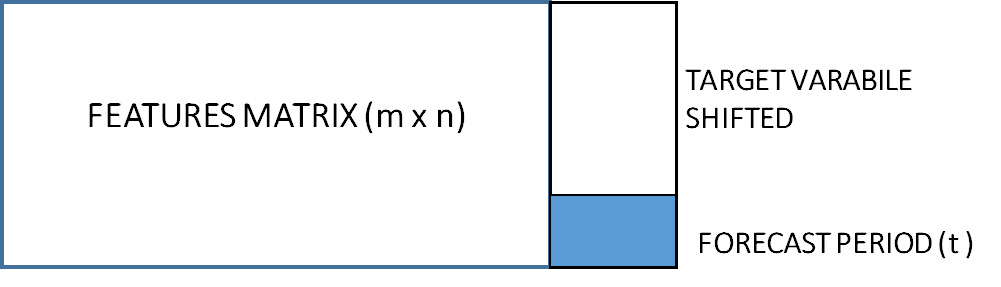

We have a features matrix of n variables and m rows. We want to predict t period in advance the target variable so we shift it t period. In this case we use the first m -t rows to predict t periods in advance.

In [ ]:
Acq_Petrignano_post_2009_res.drop(['Depth_to_Groundwater_P25','Depth_to_Groundwater_P24'], axis = 1 , inplace = True)
Acq_Petrignano_post_2009_res.dropna(inplace= True)


### 3 -  Model building

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Defining target and features variable

In [ ]:
target = ['Depth_to_Groundwater_P24_shifted', 'Depth_to_Groundwater_P25_shifted']
features = [col for col in Acq_Petrignano_post_2009_res.columns if col not in target]

In [ ]:
X = Acq_Petrignano_post_2009_res[features].values
y = Acq_Petrignano_post_2009_res[target].values

In [ ]:
print("X shape :", X.shape)
print("y shape :",y.shape)

In [ ]:
tscv = TimeSeriesSplit(n_splits = 2)

We use TimeSeriesSplit to split data between train and test. Before applying RandomForestRegressor we scale the data and then we apply GridSearch to find the best parameters for the model

This is the model I want to build.

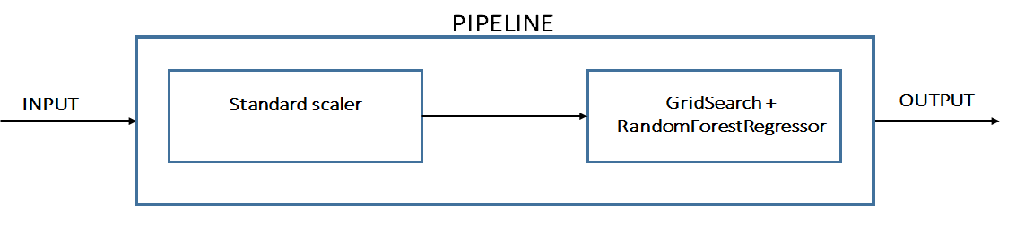

In [ ]:
for train_index, test_index in tscv.split(X):
    score = []
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    param_grid = { 'criterion': ['mse','mae'],'min_samples_split': [2,5], 'min_samples_leaf':[1,2]}
    gs = GridSearchCV(RandomForestRegressor(), param_grid)
    pipe = Pipeline([('scaler',StandardScaler()),('gs_rfr',gs)])
    pipe.fit(X_train, y_train)


Best parameters are:

In [ ]:
pipe.named_steps['gs_rfr'].best_params_

Scoring of best estimators is:

In [ ]:
pipe.named_steps['gs_rfr'].best_estimator_.score(X_test, y_test)

We can create three dataframes: first with training data, second with testing data and third with predicted data 

In [ ]:
# create training, testing and predicted dataframe
train_index_array = np.array(Acq_Petrignano_post_2009_res.iloc[train_index].index)
train_index_array=train_index_array.reshape(-1,1).astype('str')
train_array = np.hstack((train_index_array, y_train))
train_df = pd.DataFrame(train_array, columns= ['Date','Depth_to_Groundwater_P24','Depth_to_Groundwater_P25'])
train_df['Type'] = 'train'


test_index_array = np.array(Acq_Petrignano_post_2009_res.iloc[test_index].index)
test_index_array =test_index_array.reshape(-1,1).astype('str')
test_array = np.hstack((test_index_array, y_test))
test_df = pd.DataFrame(test_array, columns= ['Date','Depth_to_Groundwater_P24','Depth_to_Groundwater_P25'])
test_df['Type'] = 'test'


predict_test_index_array = np.array(Acq_Petrignano_post_2009_res.iloc[test_index].index)
predict_test_index_array = predict_test_index_array.reshape(-1,1).astype('str')
predict_test_array = np.hstack((test_index_array,pipe.named_steps['gs_rfr'].best_estimator_.predict(X_test)))
predict_test_df = pd.DataFrame(test_array, columns= ['Date','Depth_to_Groundwater_P24','Depth_to_Groundwater_P25'])
predict_test_df['Type'] = 'predicted'

In [ ]:
print("Train dataframe: ")
print(train_df.head(2))
print("Test dataframe: ")
print(test_df.head(2))
print("Predicted dataframe: ")
print(predict_test_df.head(2))

In [ ]:
df = [train_df, test_df, predict_test_df]

for d in df:
    d['Date'] = pd.to_datetime(d['Date'], format = '%Y-%m-%d')
    d['Depth_to_Groundwater_P24'] = d['Depth_to_Groundwater_P24'].astype('float')
    d['Depth_to_Groundwater_P25'] = d['Depth_to_Groundwater_P25'].astype('float')
    d.set_index('Date', inplace = True)
    

Graphs with predicted values vs true values for the two target variables are the following:

In [ ]:
fig , ax = plt.subplots(nrows = 2, ncols = 1,  figsize = (10, 8))

sns.lineplot(x =  train_df.index, y = train_df['Depth_to_Groundwater_P24'],color = 'blue', ax = ax[0], label = 'Depth_to_Groundwater_P24_training')
sns.lineplot(x =  test_df.index, y = test_df['Depth_to_Groundwater_P24'],color = 'green', ax = ax[0], label = 'Depth_to_Groundwater_P24_testing')
sns.lineplot(x =  predict_test_df.index, y = predict_test_df['Depth_to_Groundwater_P24'],color = 'red', ax = ax[0], label = 'Depth_to_Groundwater_P24_predicted')
ax[0].set_title('Predicted vs True values Depth_to_Groundwater_P24')
ax[0].set_ylabel('Depth_to_Groundwater_P24')


sns.lineplot(x =  train_df.index, y = train_df['Depth_to_Groundwater_P25'],color = 'blue', ax = ax[1], label = 'Depth_to_Groundwater_P25_training')
sns.lineplot(x =  test_df.index, y = test_df['Depth_to_Groundwater_P25'],color = 'green', ax = ax[1], label = 'Depth_to_Groundwater_P25_testing')
sns.lineplot(x =  predict_test_df.index, y = predict_test_df['Depth_to_Groundwater_P25'],color = 'red', ax = ax[1], label = 'Depth_to_Groundwater_P25_predicted')
ax[1].set_title('Predicted vs True values Depth_to_Groundwater_P25')
ax[1].set_ylabel('Depth_to_Groundwater_P25')

plt.tight_layout() 
plt.show()

We can get most important features of best estimator and create a dataframe with that  features

In [ ]:
importances =pipe.named_steps['gs_rfr'].best_estimator_.feature_importances_

In [ ]:
importances_df = pd.DataFrame(data = importances, index = features, columns = ['Importance']  )
importances_df.sort_values('Importance',ascending = False, inplace = True)
importances_df['Importance_cumulated'] = importances_df['Importance'].cumsum()  

### Plotting variable importance:

In [ ]:
sns.barplot(x =importances_df.index[:10] , y = importances_df['Importance'][:10] )
plt.xticks(rotation = 90) 
plt.title("Features importance")

The most important feature is Volume_C10_Petrignao and Hydrometry_Fiume_Cascio_Petrignano: these two variables account for more than 44% of the variation of Depth to groundwater